In [1]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior, hnn_noise_conn_prob_param_function,
                   load_posterior, simulator_hnn, get_dataset_psd, get_dataset_bandpower,
                   get_parameter_recovery, get_posterior_predictive_check)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
from neurodsp.spectral import compute_spectrum, trim_spectrum

rng_seed = 123
rng = np.random.default_rng(rng_seed)

scale_factor = 60_000

# sns.set()
# sns.set_style("white")

device = 'cpu'

data_path = '/expanse/lustre/scratch/ntolley/temp_project/beta_tuning'

# with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
#     posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)

dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
# extra_dict = posterior_metadata['extra_dict']
# window_samples = extra_dict['window_samples'] 
theta_extra = sim_metadata['theta_extra']

dpl = np.load(f'{data_path}/sbi_sims/dpl_sbi.npy')
theta = np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
spike_gids = np.load(f'{data_path}/sbi_sims/spike_gids_sbi.npy', allow_pickle=True)
spike_times = np.load(f'{data_path}/sbi_sims/spike_times_sbi.npy', allow_pickle=True)

times = np.linspace(0, 1, dpl.shape[1])
fs = 1000 / dt

--No graphics will be displayed.


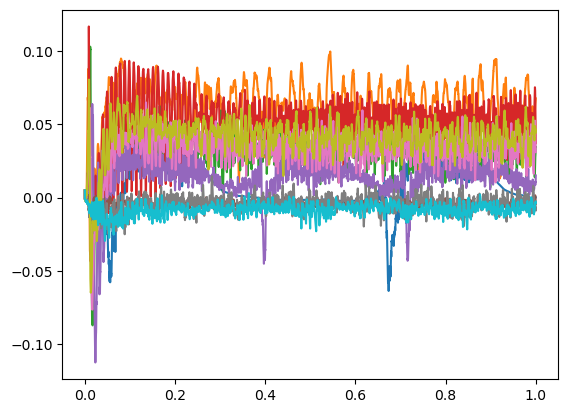

In [2]:
_ = plt.plot(times, dpl[:10,:].T)

In [3]:
mask = times > 0.2
freqs, powers = compute_spectrum(dpl[:, mask], fs, method='welch', avg_type='median')
freqs, powers = trim_spectrum(freqs, powers, [0, 100])

/home/ntolley/anaconda3/envs/sfn_2023/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 20000 is greater than input length  = 16000, using nperseg = 16000
  warnings.warn('nperseg = {0:d} is greater than input length '


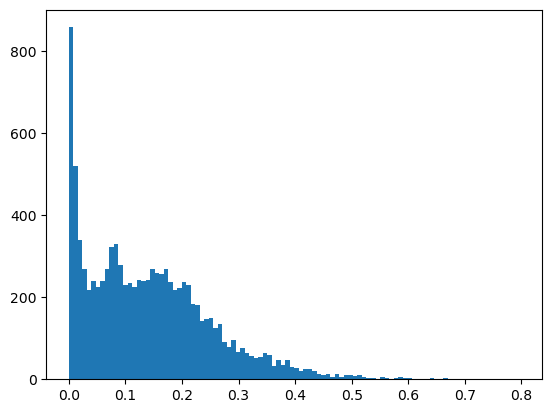

In [20]:
beta_mask = (freqs > 13) & (freqs < 30)
beta_power = powers[:, beta_mask].sum(axis=1)
beta_ratio = beta_power / powers.sum(axis=1)
ratio_sort = np.argsort(beta_ratio)[::-1]

_ = plt.hist(beta_ratio, bins=100)
# plt.xlim(0, 0.0001)
# plt.yscale('log')

In [65]:

# plt.eventplot(positions=np.array(spike_times[ratio_sort[0]]),
#               lineoffsets=np.array(spike_gids[ratio_sort[0]]), orientation='vertical')

In [58]:
# spike_times[ratio_sort[0]]

In [61]:
# spike_gids[ratio_sort[0]]

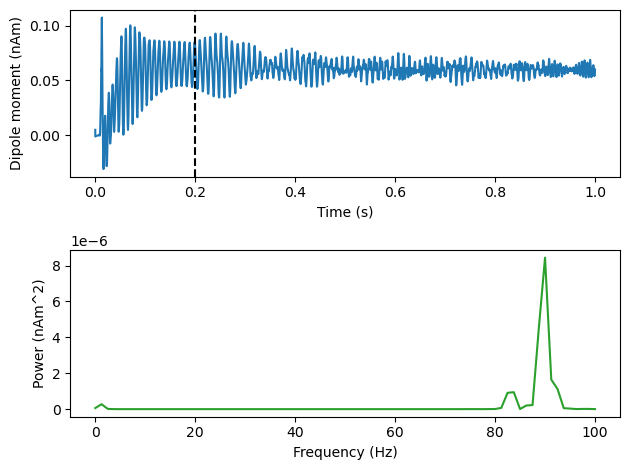

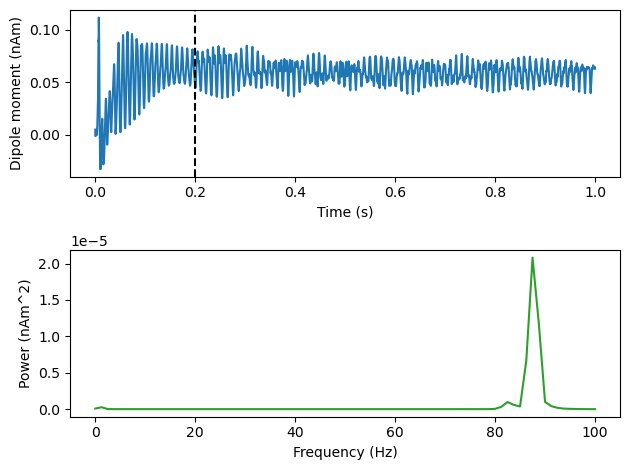

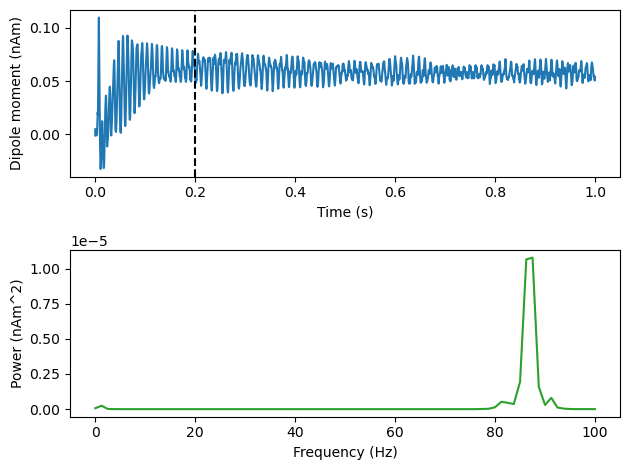

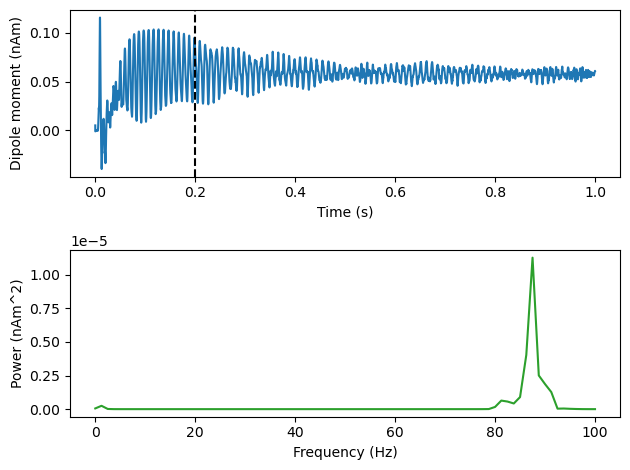

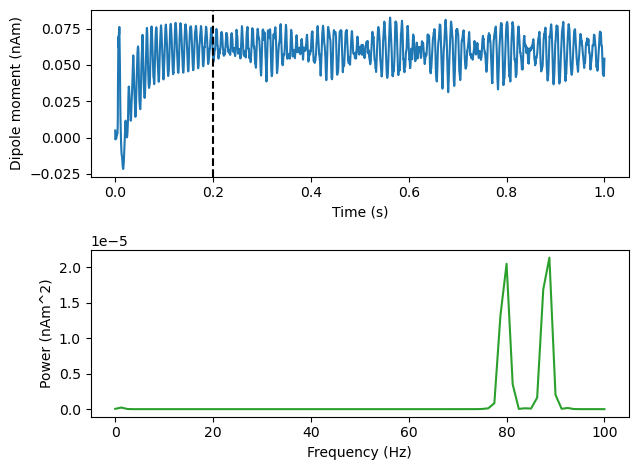

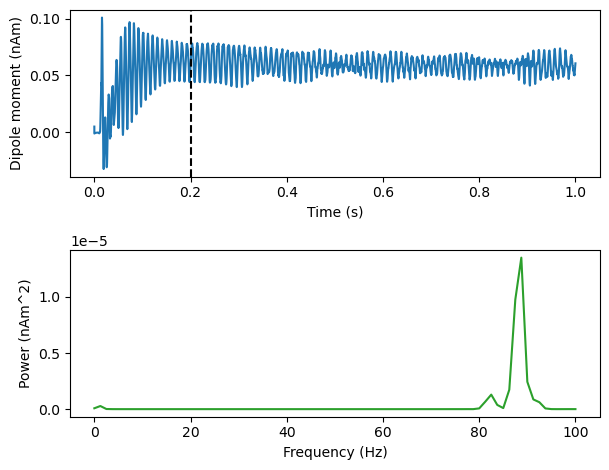

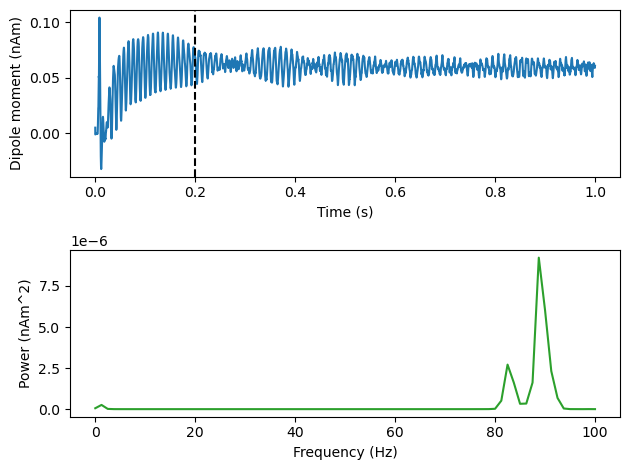

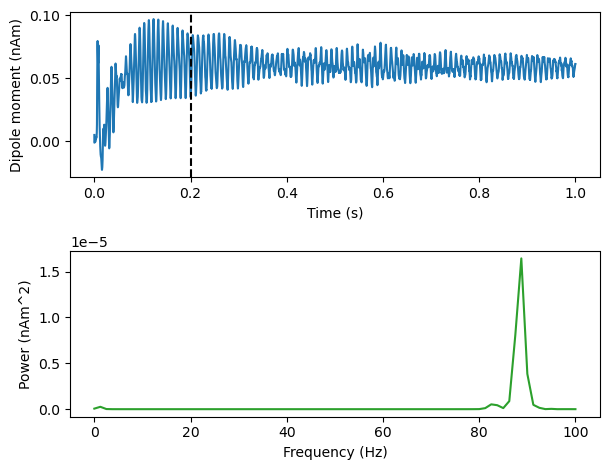

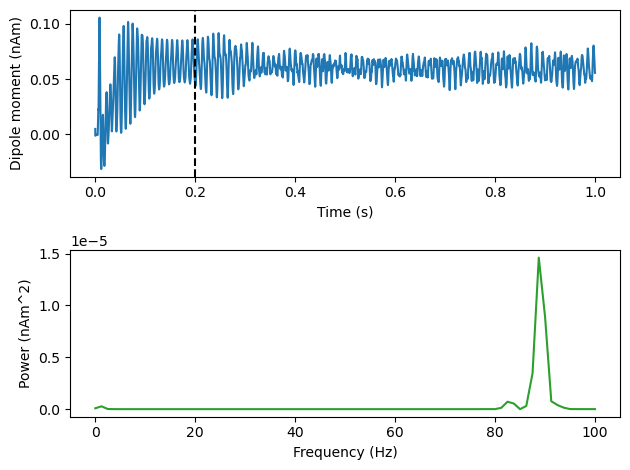

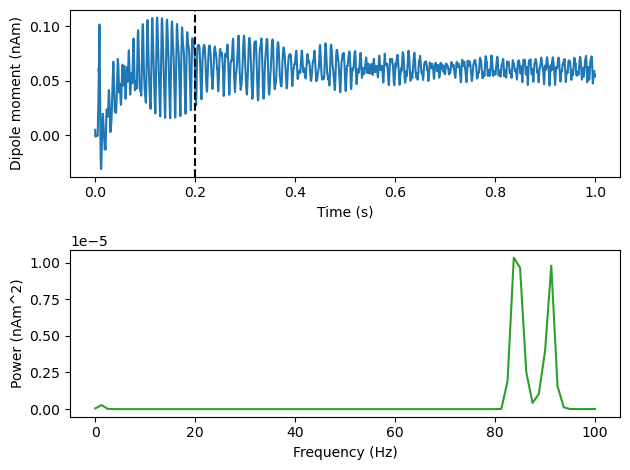

In [69]:
for sim_idx in ratio_sort[-10:]:
    sig = dpl[sim_idx,:]

    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(times, sig)
    plt.xlabel('Time (s)')
    plt.ylabel('Dipole moment (nAm)')
    plt.axvline(0.2, color='k', linestyle='--')

    plt.subplot(2,1,2)
    plt.plot(freqs,powers[sim_idx,:], color='C2')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power (nAm^2)')

    plt.tight_layout()